## Imports


In [1]:
import pandas as pd
import numpy as np

## Loading Dataset


In [2]:
# i want to put a json object in a pandas dataframe
df_1 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/AO_Output.json"
)
df_2 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/FA Output.json"
)
df_3 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/video_4_annotated.json"
)
df_4 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/integrated_data.json"
)
df_5 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/nadines_video_annotated.json"
)
df_6 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/video_1_annotated.json"
)

In [3]:
# add an index column to each dataframe
df_1["index"] = 1
df_2["index"] = 2
df_3["index"] = 3
df_4["index"] = 4
df_5["index"] = 5
df_6["index"] = 6

In [4]:
df = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

In [5]:
expanded_df = (
    df["keypoints"]
    .apply(
        lambda person: {f"x_{part}": person[part]["x"] for part in person}
        | {f"y_{part}": person[part]["y"] for part in person}
    )
    .apply(pd.Series)
)

# Merge back into original df if needed
df_expanded = pd.concat([df, expanded_df], axis=1)

# Optionally drop original nested column
df_expanded.drop(columns=["keypoints"], inplace=True)

In [6]:
# # Assuming your DataFrame is called df_expanded and is indexed properly (0, 1, 2, ...)
# event_indices = df_expanded[df_expanded["event"].notnull()].index

# # Set to store all the indices we want (to avoid duplicates)
# selected_indices = set()

# for idx in event_indices:
#     label = df_expanded.at[idx, "event"]  # Label for current event
#     selected_indices.add(idx)
#     df_expanded.at[idx, "event"] = label  # Ensure label is consistent

#     # Include next up to 15 rows, but stop early if another event is found
#     for offset in range(1, 16):  # 1 to 15
#         next_idx = idx + offset
#         if next_idx >= len(df_expanded):
#             break

#         if (
#             pd.notnull(df_expanded.at[next_idx, "event"])
#             or df_expanded["index"][next_idx] != df_expanded["index"][idx]
#         ):
#             break  # Stop if another event is found

#         selected_indices.add(next_idx)
#         df_expanded.at[next_idx, "event"] = label  # Assign current label

# # Keep only selected rows
# # df_expanded = df_expanded.loc[sorted(selected_indices)].reset_index(drop=True)

In [7]:
event_indices = df_expanded[df_expanded["event"].notnull()].index

selected_indices = set()
neither_count = 0
MAX_NEITHER_SEGMENTS = 250

# Step 1: Annotate labeled events and their 15-frame tails
for idx in event_indices:
    label = df_expanded.at[idx, "event"]
    group_id = df_expanded.at[idx, "index"]
    selected_indices.add(idx)
    df_expanded.at[idx, "event"] = label

    for offset in range(1, 16):
        next_idx = idx + offset
        if next_idx >= len(df_expanded):
            break

        if (
            pd.notnull(df_expanded.at[next_idx, "event"])
            or df_expanded.at[next_idx, "index"] != group_id
        ):
            break

        selected_indices.add(next_idx)
        df_expanded.at[next_idx, "event"] = label

# Step 2: Annotate null event segments in 16-frame "neither" batches
null_indices = df_expanded[df_expanded["event"].isnull()].index
null_indices = sorted(null_indices)

i = 0
while i < len(null_indices):
    if neither_count >= MAX_NEITHER_SEGMENTS:
        break

    start_idx = null_indices[i]
    group_id = df_expanded.at[start_idx, "index"]

    # Collect consecutive nulls in same group
    segment = [start_idx]
    for j in range(i + 1, len(null_indices)):
        current_idx = null_indices[j]
        prev_idx = null_indices[j - 1]

        if (
            current_idx == prev_idx + 1
            and df_expanded.at[current_idx, "index"] == group_id
        ):
            segment.append(current_idx)
        else:
            break

    # Process in batches of 16
    for k in range(0, len(segment), 16):
        if neither_count >= MAX_NEITHER_SEGMENTS:
            break

        batch = segment[k : k + 16]
        if len(batch) == 16:
            for idx in batch:
                selected_indices.add(idx)
                df_expanded.at[idx, "event"] = "neither"
            neither_count += 1

    i += len(segment)

# Step 3: Final filtering
df_expanded = df_expanded.loc[sorted(selected_indices)].reset_index(drop=True)

print(f"Number of 'neither' segments (16-frame batches): {neither_count}")

Number of 'neither' segments (16-frame batches): 250


In [8]:
# check if there are any null values in the dataframe
print(df_expanded.isnull().sum())

frame               0
time                0
event               0
player_id           0
index               0
x_left_shoulder     0
x_right_shoulder    0
x_left_elbow        0
x_right_elbow       0
x_left_wrist        0
x_right_wrist       0
x_left_hip          0
x_right_hip         0
x_left_knee         0
x_right_knee        0
x_left_ankle        0
x_right_ankle       0
y_left_shoulder     0
y_right_shoulder    0
y_left_elbow        0
y_right_elbow       0
y_left_wrist        0
y_right_wrist       0
y_left_hip          0
y_right_hip         0
y_left_knee         0
y_right_knee        0
y_left_ankle        0
y_right_ankle       0
dtype: int64


In [9]:
df_expanded.shape

(10987, 29)

In [10]:
# df_expanded.to_csv("annotated jsons\combined_data_2.csv", index=False)

## Better Approach (LSTM - 30 Frames per event)


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

2025-09-28 20:52:58.334166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-28 20:52:58.336538: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-28 20:52:58.342506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759081978.352600   61922 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759081978.355509   61922 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759081978.363015   61922 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [12]:
lstm_df = df_expanded.copy()

In [13]:
# ----------------------------
# Step 1: Normalize coordinates
# ----------------------------
coord_cols = [
    col for col in lstm_df.columns if col.startswith("x") or col.startswith("y")
]
scaler = MinMaxScaler()
lstm_df[coord_cols] = scaler.fit_transform(lstm_df[coord_cols])

In [14]:
lstm_df.drop(columns=["player_id", "time", "index"], inplace=True)

In [15]:
# Step 2: Label encoding
# ----------------------------
label_map = {"forehand": 0, "backhand": 1, "neither": 2}
lstm_df = lstm_df[lstm_df["event"].isin(label_map.keys())].copy()
lstm_df["event"] = lstm_df["event"].map(label_map).astype(int)

In [16]:
# Data preparation with non-overlapping windows
X = []
y = []
window_size = 16

# Process the data in non-overlapping chunks of size 16
for i in range(0, len(lstm_df), window_size):
    # Check if we have a full window
    if i + window_size <= len(lstm_df):
        window = lstm_df.iloc[i : i + window_size]

        # Only use the window if all rows have the same event
        if window["event"].nunique() == 1:
            X.append(
                window[coord_cols].values
            )  # Shape: (16, 24) - 16 timesteps, 24 features
            # Store the single event for this window
            y.append(window["event"].iloc[0])

X = np.array(X)  # shape should be (num_non_overlapping_windows, 16, 24)
y = np.array(y)  # shape should be (num_non_overlapping_windows,)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Label distribution: {np.unique(y, return_counts=True)}")

X shape: (506, 16, 24)
y shape: (506,)
Label distribution: (array([0, 1, 2]), array([ 90, 209, 207]))


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
y_val

array([1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1,
       0, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1,
       1, 2, 0, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1,
       1, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2])

In [19]:
model = Sequential()
# Input shape: (16 timesteps, 24 features)
model.add(LSTM(4, input_shape=(window_size, len(coord_cols)), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))  # 3 classes (0, 1, 2)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

E0000 00:00:1759081979.978698   61922 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1759081979.978826   61922 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759081979.979308   61922 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/g03-s2025/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. Wh

In [20]:
# ----------------------------
# Step 6: Training
# ----------------------------
# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,  # You can adjust this batch size for training
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2650 - loss: 1.1168 - val_accuracy: 0.4216 - val_loss: 1.0559
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3984 - loss: 1.0489 - val_accuracy: 0.5588 - val_loss: 0.9207
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6119 - loss: 0.8609 - val_accuracy: 0.7549 - val_loss: 0.7334
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6983 - loss: 0.7473 - val_accuracy: 0.6667 - val_loss: 0.7245
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6623 - loss: 0.7518 - val_accuracy: 0.7353 - val_loss: 0.6433
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7043 - loss: 0.6849 - val_accuracy: 0.7255 - val_loss: 0.6128
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7508 - loss: 0.6374 - val_accuracy: 0.7353 - val_loss: 0.5798
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7575 - loss: 0.6137 - val_accuracy: 0.7157 - val_loss:

In [21]:
# print classification report


# Evaluate the model
y_pred = np.argmax(model.predict(X_val), axis=1)
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        18
           1       0.92      0.83      0.88        42
           2       0.76      0.90      0.83        42

    accuracy                           0.82       102
   macro avg       0.82      0.78      0.80       102
weighted avg       0.83      0.82      0.82       102



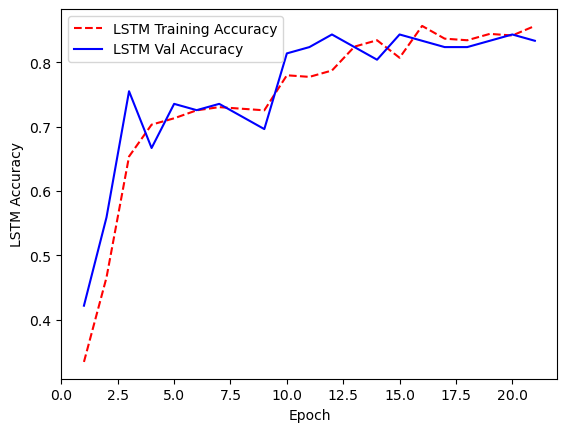

In [22]:
# Get training and validation accuracy histories
import matplotlib.pyplot as plt

training_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

EPOCHS = early_stop.stopped_epoch + 1

# Create count of the number of epochs
epoch_count = range(1, EPOCHS + 1)

# Visualize accuracy history
plt.figure()
plt.plot(epoch_count, training_acc, "r--")
plt.plot(epoch_count, val_acc, "b-")
plt.legend(["LSTM Training Accuracy", "LSTM Val Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("LSTM Accuracy")
plt.show()